In [443]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from importlib import reload
import mathutils
import fitsio
import setcover
import scipy.optimize as op

In [9]:
import ebossspec

In [10]:
masterwave, allflux, allivar = ebossspec.rest_allspec_readin()
objs_ori = ebossspec.elg_readin()
nobj = objs_ori.size
galaxytype = objs_ori['CLASS']
zgood = objs_ori['zGOOD']
z = objs_ori['Z']

Reading /Users/Benjamin/AstroData/AllInOne/AIO_ELG_eBOSS_SDSSRestFrame_Wave01800_03600A.fits.
Reading /Users/Benjamin/AstroData/AllInOne/AIO_ELG_eBOSS_SDSSRestFrame_Wave03600_07200A.fits.
Reading /Users/Benjamin/AstroData/AllInOne/AIO_ELG_eBOSS_SDSSRestFrame_Wave07200_10400A.fits.


In [50]:
index_wave_all = np.searchsorted(masterwave, [3605., 5199.])
tmpflux = allflux[index_wave_all[0]:index_wave_all[1],:]
tmpivar = allivar[index_wave_all[0]:index_wave_all[1],:]
tmpwave = masterwave[index_wave_all[0]:index_wave_all[1]]
tmploglam = np.log10(tmpwave)

In [37]:
median_sn = np.zeros(objs_ori.size)
for i in np.arange(objs_ori.size):
    iuse = (np.where(tmpivar[:,i]>0))[0]
    if iuse.size>0:
        median_sn[i] = np.median(tmpflux[iuse,i]*np.sqrt(tmpivar[iuse,i]))

In [78]:
iuse = (np.where(np.logical_and(np.logical_and(\
                np.logical_and(np.logical_and(zgood==1, galaxytype==b'GALAXY'), median_sn>3.),\
                                               z<0.9), z>0.1)))[0]
print(iuse.shape)

(1015,)


In [95]:
newwave = np.median(tmpwave.reshape(1590//15, 15), axis=1)
newflux = np.sum(tmpflux.reshape(1590//15, 15, tmpflux.shape[1]), axis=1)
newivar = 1./np.sum(1./tmpivar.reshape(1590//15, 15, tmpflux.shape[1]), axis=1)

In [98]:
np.count_nonzero(newflux[..., iuse]<0)/newflux[...,iuse].size

0.0001951854261548471

(0, 20.0)

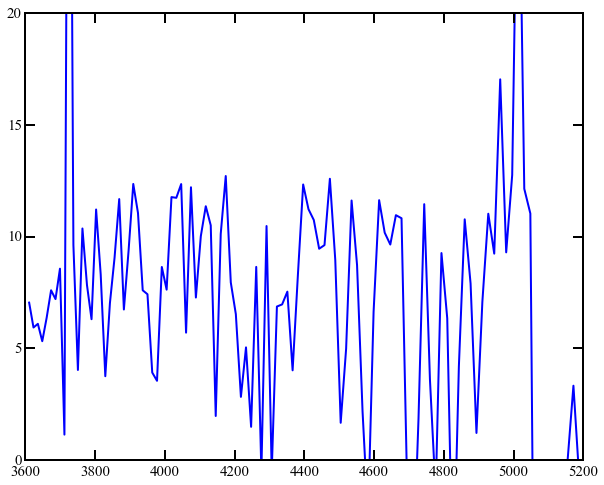

In [70]:
i += 1
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(newwave, newflux[:,iuse[i]])
ax.set_ylim(0,20.)

In [470]:
chi2 = np.zeros((iuse.size, iuse.size))
A = np.zeros((iuse.size, iuse.size))

In [471]:
tmp_yerr = 1./np.sqrt(newivar[:, iuse].T.reshape(iuse.size, newwave.size))
tmp_y = newflux[:,iuse].T
for i in np.arange(iuse.size):
    tmp_x = newflux[:, iuse[i]].T.reshape(1,newwave.size)
    tmp_xerr = 1./np.sqrt(newivar[:, iuse[i]].T.reshape(1,newwave.size))
    A_tmp, chi2_tmp = mathutils.quick_amplitude(tmp_x, tmp_y, tmp_xerr, tmp_yerr)
    A[i,:] = A_tmp
    chi2[i,:] = chi2_tmp

In [103]:
chi2 = chi2/(iuse.size-1)

In [168]:
a_matrix = chi2<0.15
cost = np.ones(iuse.size)

In [131]:
a_matrix.shape

(1015, 1015)

In [135]:
reload(setcover)
reload(setcover)

<module 'setcover' from '/Users/Benjamin/Code/BGT-Cosmology/Spectroscopy/archetype/setcover.py'>

In [169]:
g = setcover.SetCover(a_matrix, cost)

In [170]:
g.CFT()

Best solution: UB=127.0, LB=50.71068426148428, UB1=127.0, LB1=50.71068426148428
127.0
UB=127.0, UB1=127.0, LB=50.71068426148428, change=60.07032735316198%
Best solution: UB=127.0, LB=50.66116990572136, UB1=127.0, LB1=50.66116990572136
127.0
UB=127.0, UB1=127.0, LB=50.66116990572136, change=60.10931503486508%
Best solution: UB=127.0, LB=50.69142840159688, UB1=127.0, LB1=50.69142840159688
127.0
UB=127.0, UB1=127.0, LB=50.69142840159688, change=60.085489447561514%
Best solution: UB=127.0, LB=50.6499996324374, UB1=127.0, LB1=50.6499996324374
127.0
UB=127.0, UB1=127.0, LB=50.6499996324374, change=60.11811052563984%
Best solution: UB=127.0, LB=50.61333896303684, UB1=127.0, LB1=50.61333896303684
127.0
UB=127.0, UB1=127.0, LB=50.61333896303684, change=60.14697719445918%
Best solution: UB=127.0, LB=50.55517672580025, UB1=127.0, LB1=50.55517672580025
127.0
UB=127.0, UB1=127.0, LB=50.55517672580025, change=60.192774231653345%
Best solution: UB=127.0, LB=50.62593749625567, UB1=127.0, LB1=50.625937

/Users/Benjamin/Code/BGT-Cosmology/Spectroscopy/archetype/setcover.py:391: UserWarning: Iteration reaches maximum = 10
  warnings.warn("Iteration reaches maximum = {0}".format(niters))


In [120]:
i = 20
j = 20
print(chi2[i,j], chi2[j,i], A[i,j], A[j,i])

0.0 0.0 1.0 1.0


In [122]:
print(np.median(chi2))

0.397000722252


In [171]:
iarchetype = np.nonzero(g.s)[0]

In [172]:
tmpmedian = np.zeros((iarchetype.size, tmpwave.size))

In [177]:
for i in np.arange(iarchetype.size):
    itmp = a_matrix[:, iarchetype[i]]
    for j in np.arange(tmpwave.size):
        tmpmedian[i, j] = np.median(tmpflux[j,iuse[itmp]])

23 16
24 12


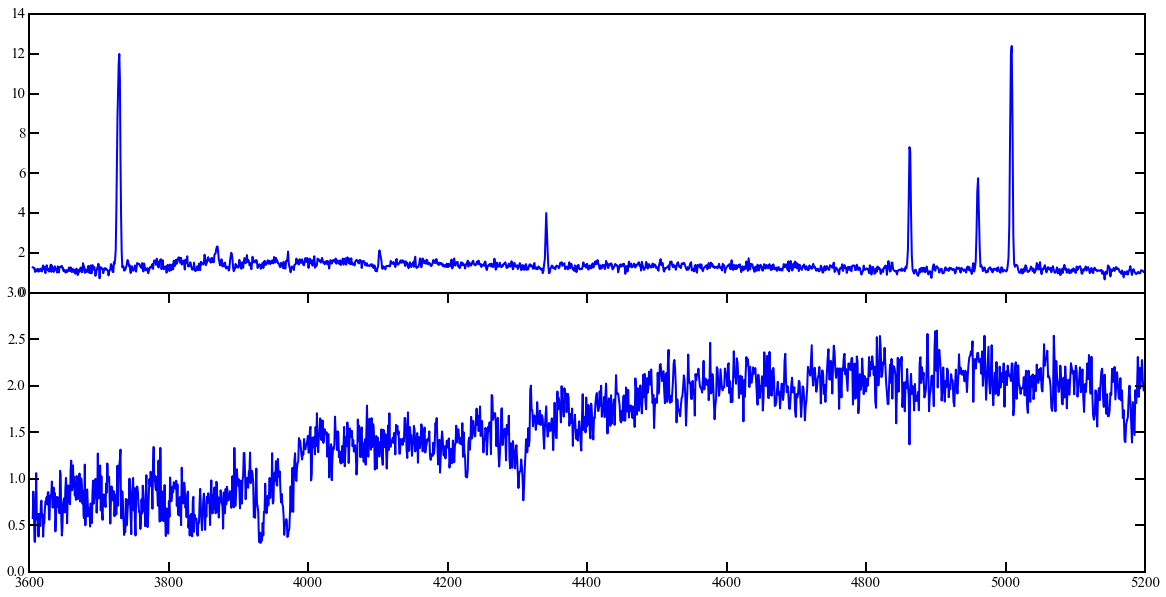

In [513]:
#itmp = np.nonzero(iarchetype)[0]
#n_rep = np.sum(a_matrix[:,itmp], axis=0)
n_rep = np.sum(a_matrix[:, iarchetype], axis=0)
isort = np.argsort(n_rep)[::-1]
#print(isort.shape, isort)
#i = 0
i += 1
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(211)
ax.plot(tmpwave, tmpmedian[isort[i],:])
ax.set_xticks([])
print(i, np.count_nonzero(a_matrix[:,iarchetype[isort[i]]]))
i += 1
ax = fig.add_subplot(212)
ax.plot(tmpwave, tmpmedian[isort[i],:])
print(i, np.count_nonzero(a_matrix[:,iarchetype[isort[i]]]))

In [229]:
i, iarchetype[i], iarchetype.size

(43, 395, 127)

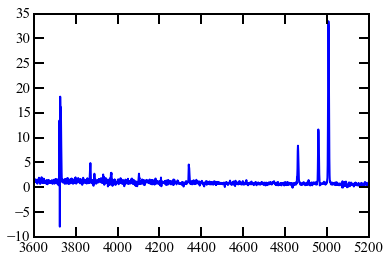

In [182]:
plt.plot(tmpwave, tmpflux[:,iuse[26]])

In [426]:
a = np.arange(100)*np.pi/100
x = ((np.sin(a)+2.)*0.4+np.random.randn(100)*1.).reshape(1,100)
y = ((np.sin(a)+2.)*2.4+np.random.randn(100)*1.).reshape(1,100)

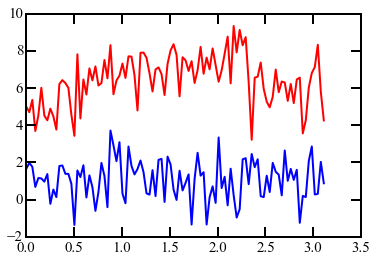

In [427]:
plt.plot(a, x[0,:], 'b')
plt.plot(a, y[0,:], 'r')

In [428]:
x_err = np.ones((1,100))+np.random.randn(1,100)*0.1
y_err = np.ones((1,100))+np.random.randn(1,100)*0.1

In [472]:
t_chi2 = lambda A: np.einsum('ij, ij->i', np.square(y-A*x), 1./(np.square(y_err)+np.square(A)*np.square(x_err)))

In [434]:
xy = x*y
xx = x*x
A0 = np.ones(x.shape[0])

[ 3.07368741]
[ 3.07368741]
[ 3.07368741]
[ 3.07368741]
[ 3.07368741]
[ 3.07368741]


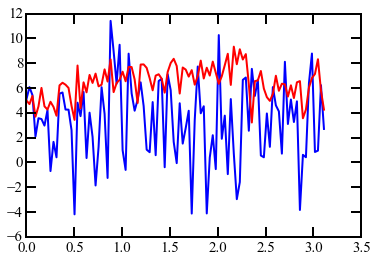

In [436]:
for i in np.arange(6):
    print(A0)
    weight = 1./(np.square(y_err)+np.square(A0).reshape(A0.size, 1)*np.square(x_err))
    A0 = np.einsum('ij, ij->i', xy, weight)/np.einsum('ij, ij->i', xx, weight)
plt.plot(a, x[0,:]*A0, 'b')
plt.plot(a, y[0,:], 'r')

In [437]:
A0

array([ 3.07368741])

In [473]:
res = op.minimize(t_chi2, A0)

In [474]:
res

   status: 0
  success: True
      jac: array([ 0.])
      fun: 119.90473924561275
  message: 'Optimization terminated successfully.'
        x: array([ 5.85179445])
 hess_inv: array([[ 0.13221746]])
     njev: 20
     nfev: 60
      nit: 6

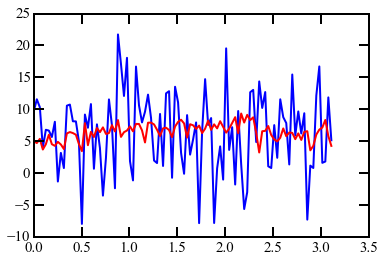

In [441]:
plt.plot(a, x[0,:]*res['x'], 'b')
plt.plot(a, y[0,:], 'r')

In [457]:
reload(mathutils)
reload(mathutils)

<module 'mathutils' from '/Users/Benjamin/Code/BGT-Cosmology/Spectroscopy/archetype/mathutils.py'>

In [449]:
rr, cc = mathutils.quick_totalleastsquares(x, y, x_err, y_err)

In [451]:
res_chi2 = np.zeros((iuse.size, iuse.size))
res_A = np.zeros((iuse.size, iuse.size))

In [465]:
tmp_yerr = 1./np.sqrt(newivar[:, iuse].T.reshape(iuse.size, newwave.size))
tmp_y = newflux[:,iuse].T
#for i in np.arange(iuse.size):
for i in np.arange(10):
    for j in np.arange(iuse.size):
        tmp_x = newflux[:, iuse[i]].T.reshape(1,newwave.size)
        tmp_xerr = 1./np.sqrt(newivar[:, iuse[i]].T.reshape(1,newwave.size))
        res_tmp, chi2_tmp = mathutils.quick_totalleastsquares(tmp_x, tmp_y[j,:], tmp_xerr, tmp_yerr[j,:])
        res_A[i,j] = res_tmp['x']
        res_chi2[i,j] = chi2_tmp

In [468]:
res_chi2/(iuse.size-1)

array([[ 0.        ,  0.24138563,  0.20405791, ...,  3.99508807,
         5.54208359,  4.62233886],
       [ 0.24138563,  0.        ,  0.21950779, ...,  2.87644243,
         3.51620716,  2.54826493],
       [ 0.20405791,  0.21950779,  0.        , ...,  2.14704513,
         2.95484434,  2.63047102],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [476]:
chi2/(iuse.size-1)

array([[ 0.        ,  0.24257197,  0.20460389, ...,  4.18375045,
         5.92292824,  5.08725562],
       [ 0.24426466,  0.        ,  0.22179025, ...,  3.11783771,
         4.02772495,  2.92064389],
       [ 0.20633534,  0.22112813,  0.        , ...,  2.2155028 ,
         3.14379945,  2.82645258],
       ..., 
       [ 4.67383308,  3.11864473,  2.39795328, ...,  0.        ,
         0.19250085,  0.3605201 ],
       [ 6.41482833,  3.72295939,  3.21517208, ...,  0.19237276,
         0.        ,  0.44396171],
       [ 5.02011485,  2.61803386,  2.77655439, ...,  0.35917274,
         0.44208818,  0.        ]])

In [480]:
np.count_nonzero(np.isfinite(chi2))/1015

1015.0

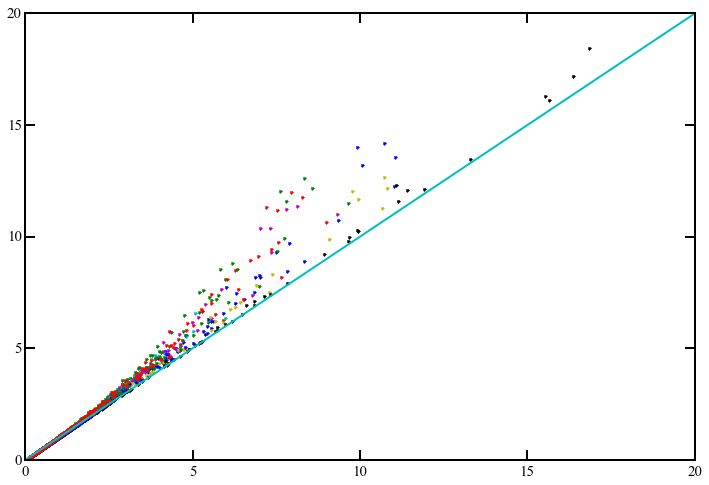

In [486]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in np.arange(10):
    ax.plot(res_chi2[i, :]/1015., chi2[i, :]/1015., '.')
ax.plot([0,20], [0,20])

(0, 1014)

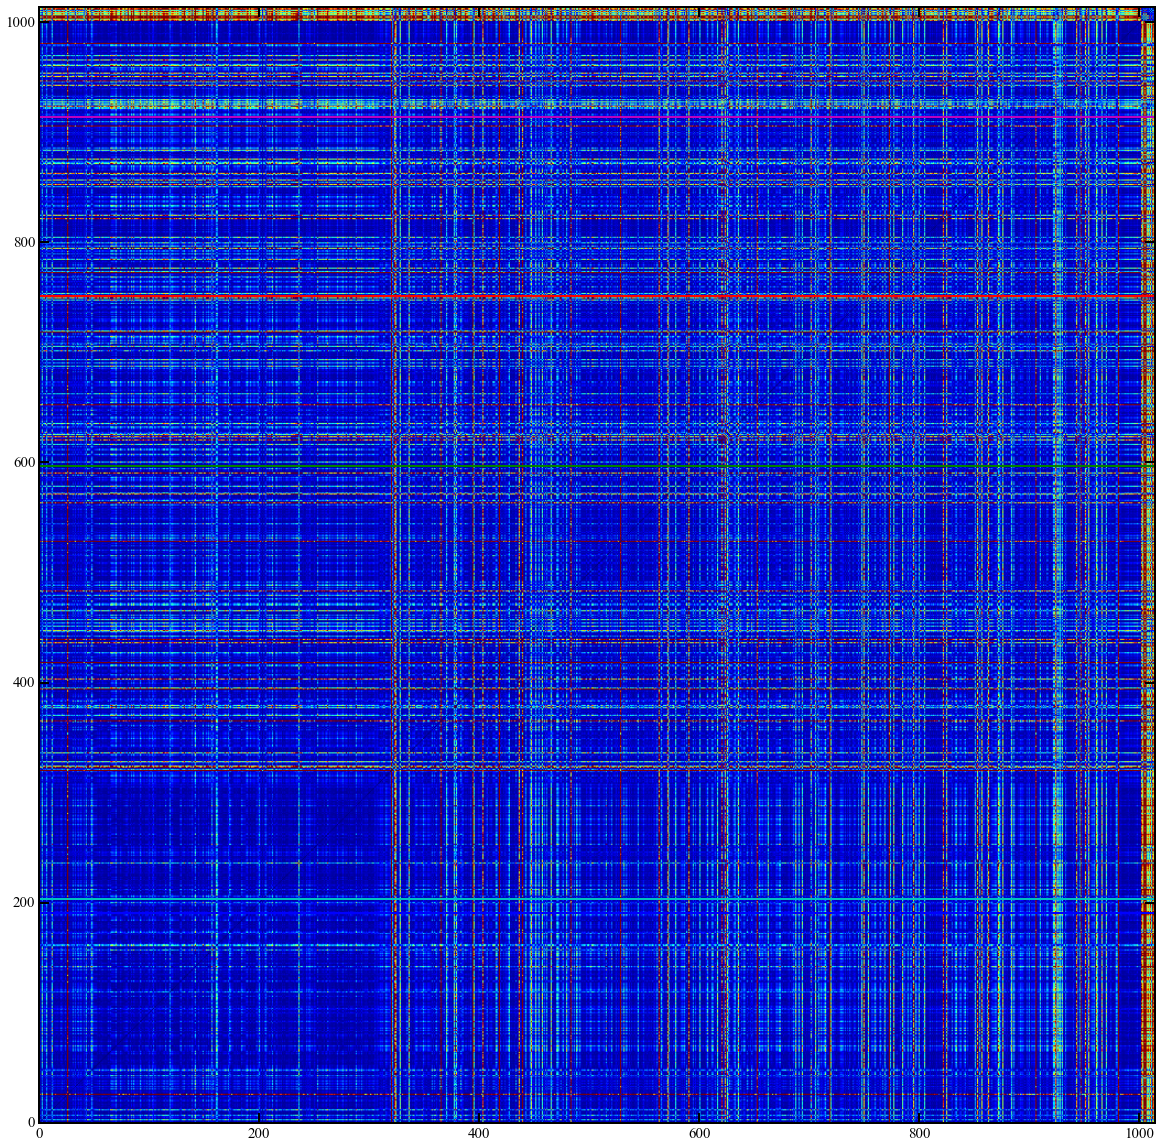

In [521]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.imshow(chi2/1015., vmin=0, vmax=5)#, cmap=plt.get_cmap('rainbow'))
for i in np.arange(5):
    ax.plot([0,1014], [iarchetype[isort[i]],iarchetype[isort[i]]])
ax.set_xlim(0,1014)
ax.set_ylim(0,1014)

In [503]:
iarchetype

array([   3,   26,   41,   61,   70,   93,  104,  116,  119,  121,  123,
        127,  128,  136,  139,  145,  157,  159,  162,  164,  191,  192,
        203,  230,  236,  241,  244,  246,  281,  297,  305,  307,  311,
        319,  320,  323,  328,  336,  341,  365,  381,  384,  394,  395,
        403,  418,  424,  427,  436,  447,  448,  451,  457,  465,  471,
        514,  528,  533,  558,  563,  567,  581,  590,  597,  600,  611,
        616,  619,  620,  625,  627,  632,  634,  635,  652,  655,  662,
        670,  685,  702,  705,  713,  718,  722,  730,  744,  751,  753,
        772,  779,  794,  796,  804,  821,  824,  856,  865,  873,  875,
        879,  883,  905,  907,  914,  921,  923,  924,  927,  929,  932,
        945,  946,  950,  951,  963,  969,  971,  989, 1001, 1002, 1003,
       1004, 1005, 1011, 1012, 1013, 1014])

In [505]:
tmpwave.shape

(1590,)

In [506]:
tmpmedian.shape

(127, 1590)